- <font color='red'>step 1</font>: Choose any vectorizer (data matrix) that you have worked in any of the assignments, and got the best AUC value.
- <font color='red'>step 2</font>: Choose any of the <a href='https://scikit-learn.org/stable/modules/feature_selection.html'>feature selection</a>/<a href='https://scikit-learn.org/stable/modules/decomposition.html'>reduction algorithms</a> ex: selectkbest features, pretrained word vectors, model based feature selection etc and reduce the number of features to 5k features
- <font color='red'>step 3</font>: Apply all three kmeans, Agglomerative clustering, DBSCAN
    - <strong>K-Means Clustering:</strong> <br>
        ● Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)<br>
    - <strong>Agglomerative Clustering: </strong><br>
        ● Apply <a href='https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/'>agglomerative algorithm</a> and try a different number of clusters like 2,5 etc. <br>
        ● You can take less data points (as this is very computationally expensive one) to perform hierarchical clustering because they do take a considerable amount of time to run. <br>
    - <strong>DBSCAN Clustering: </strong><br>
        ● Find the best ‘eps’ using the <a href='https://stackoverflow.com/a/48558030/4084039'>elbow-knee method</a>.<br>
        ● You can take a smaller sample size for this as well.
- <font color='red'>step 4</font>: Summarize each cluster by manually observing few points from each cluster.
- <font color='red'>step 5</font>: You need to plot the word cloud with essay text for each cluster for each of algorithms mentioned in <font color='red'>step 3</font>.

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.naive_bayes import MultinomialNB
from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter
from math import *
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report,f1_score

#### Read the CSV file project and resorce.

In [ ]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [ ]:
project_data.shape

(109248, 17)

In [ ]:
resource_data.shape

(1541272, 4)

    • There are 109248 datapoints and 17 features in project file.
    • There are 1541272  datapoints and 4 features in resource file.

In [ ]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [ ]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity'],
      dtype='object')

In [ ]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]
#As data is huge, due to computation limitation we will randomly select data. we will try to pick data in a way so that it doesn't make data imbalance problem
project_data_approve = project_data[project_data.project_is_approved == 1]
project_data_approve = project_data_approve.sample(n = 60000) #0.055
project_data_reject = project_data[project_data.project_is_approved == 0]
project_data_reject = project_data_reject.sample(n = 10500) #0.25
project_data_temp = pd.concat([project_data_approve,project_data_reject],axis=0)

#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data_temp['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data_temp.drop('project_submitted_datetime', axis=1, inplace=True)
project_data_temp.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data_temp = project_data_temp[cols]

# merge two column text dataframe: 
project_data_temp["essay"] = project_data_temp["project_essay_1"].map(str) +\
                        project_data_temp["project_essay_2"].map(str) + \
                        project_data_temp["project_essay_3"].map(str) + \
                        project_data_temp["project_essay_4"].map(str)

In [ ]:
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

### • Splitting Data

project_data = project_data[project_data['teacher_prefix'].isnull() == False]
X = project_data_temp
y = project_data_temp["project_is_approved"]
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

In [ ]:
project_data = project_data[project_data['teacher_prefix'].isnull() == False]
X = project_data 
y = project_data["project_is_approved"]
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(49039, 20)
(24155, 20)
(36051, 20)


### school_state : categorical data (one hot encoding)

In [ ]:
# we use count vectorizer to convert the values into one hot encoded features
state_list = list(np.unique(X_train['school_state']))
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=state_list, lowercase=False, binary=True)
vectorizer.fit(X_train['school_state'].values)
#print(vectorizer.get_feature_names())
vectorizer_school_train = vectorizer
school_state_train = vectorizer.transform(X_train['school_state'].values)
print("Shape of matrix train data after one hot encodig ",school_state_train.shape)

Shape of matrix train data after one hot encodig  (49039, 51)


In [ ]:
vectorizer.fit(X_cv['school_state'].values)
#print(vectorizer.get_feature_names())
vectorizer = CountVectorizer(vocabulary=state_list, lowercase=False, binary=True)
school_state_cv = vectorizer.transform(X_cv['school_state'].values)
print("Shape of matrix CV data after one hot encodig ",school_state_cv.shape)
vectorizer_school_cv = vectorizer
#print(vectorizer.get_feature_names())
vectorizer = CountVectorizer(vocabulary=state_list, lowercase=False, binary=True)
vectorizer.fit(X_test['school_state'].values)
#print(vectorizer.get_feature_names())
vectorizer_school_test = vectorizer
school_state_test = vectorizer.transform(X_test['school_state'].values)
print("Shape of matrix Test data after one hot encodig ",school_state_test.shape)
p_feature  = []
p_feature = list(vectorizer_school_train.get_feature_names())
p_feature_dataframe = pd.DataFrame(data=p_feature)

Shape of matrix CV data after one hot encodig  (24155, 51)
Shape of matrix Test data after one hot encodig  (36051, 51)


### Observation:
    Shape of matrix of school_state after one hot encodig  :
     • train data (49039, 51)
     • CV data (24155, 51)
     • test data (36051, 51)

### clean_categories : categorical data (one hot encoding)

In [ ]:

def clean_categories (catogories,X):
    
#    catogories = list(project_data_temp['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
    cat_list = []
    for i in catogories:
        temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
        for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
            if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
                j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
            j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
            temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
            temp = temp.replace('&','_') # we are replacing the & value into 
        cat_list.append(temp.strip())
    X['clean_categories'] = cat_list   

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
    from collections import Counter
    my_counter = Counter()
    for word in X['clean_categories'].values:
        my_counter.update(word.split())

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
    clean_cat_dict = dict(my_counter)
    sorted_clean_cat_dict = dict(sorted(clean_cat_dict.items(), key=lambda kv: kv[1]))
    return sorted_clean_cat_dict

    

In [ ]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
    
catogories = list(X_train['project_subject_categories'].values)
categories_train_1  =  clean_categories(catogories,X_train)
vectorizer_categories_train = CountVectorizer(vocabulary=list(categories_train_1.keys()), lowercase=False, binary=True)
categories_train = vectorizer_categories_train.fit_transform(X_train['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_train.shape)

Shape of matrix after one hot encodig  (49039, 9)


In [ ]:
catogories = list(X_cv['project_subject_categories'].values)
categories_cv_1 =  clean_categories(catogories,X_cv)
vectorizer_categories_cv = CountVectorizer(vocabulary=list(categories_cv_1.keys()), lowercase=False, binary=True)
categories_cv = vectorizer_categories_cv.fit_transform(X_cv['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_cv.shape)

catogories = list(X_test['project_subject_categories'].values)
categories_test_1 =  clean_categories(catogories,X_test)
vectorizer_categories_test = CountVectorizer(vocabulary=list(categories_test_1.keys()), lowercase=False, binary=True)
categories_test = vectorizer_categories_test.fit_transform(X_test['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_test.shape)
#p_feature.append(vectorizer_categories_test.get_feature_names())
p_feature_dataframe.append(vectorizer_categories_test.get_feature_names())
#print(p_feature)
#print("Shape of matrix Test data after one hot encodig ",school_state_test.shape)
p_feature  = []
p_feature = list(vectorizer_categories_train.get_feature_names())
p_feature_dataframe1 = pd.DataFrame(data=p_feature)
p_feature_dataframe = pd.concat([p_feature_dataframe,p_feature_dataframe1],ignore_index=True)

Shape of matrix after one hot encodig  (24155, 9)
Shape of matrix after one hot encodig  (36051, 9)


### Observation:
    Shape of matrix of clean_categories after one hot encodig  :
     • train data (49039, 9)
     • CV data (24155, 9)
     • test data (36051, 9)

### clean_subcategories : categorical data (one hot encoding)

In [ ]:
#sub_catogories = list(project_data_temp['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
#vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
def clean_subcategories(sub_catogories,X):
    sub_cat_list = []
    for i in sub_catogories:
        temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
        for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
            if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
                j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
            j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
            temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
            temp = temp.replace('&','_')
        sub_cat_list.append(temp.strip())

    X['clean_subcategories'] = sub_cat_list
 #   X.drop(['project_subject_subcategories'], axis=1, inplace=True)

    catogories = list(X['project_subject_categories'].values)


# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
    from collections import Counter
    my_counter = Counter()
    for word in X['clean_subcategories'].values:
        my_counter.update(word.split())

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
    sub_cat_dict = dict(my_counter)
    sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))
    return sorted_sub_cat_dict 
# we use count vectorizer to convert the values into one hot encoded features


In [ ]:

from sklearn.feature_extraction.text import CountVectorizer
    
sub_catogories = list(X_train['project_subject_subcategories'].values)
sub_categories_train_1 =  clean_subcategories(sub_catogories,X_train)
vectorizer_sub_cat_train  = CountVectorizer(vocabulary=list(sub_categories_train_1.keys()), lowercase=False, binary=True)
sub_categories_train = vectorizer_sub_cat_train.fit_transform(X_train['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_train.shape)

sub_catogories = list(X_cv['project_subject_subcategories'].values)
sub_categories_cv_1 =  clean_subcategories(sub_catogories,X_cv)
vectorizer_sub_cat_cv  = CountVectorizer(vocabulary=list(sub_categories_cv_1.keys()), lowercase=False, binary=True)
sub_categories_cv = vectorizer_sub_cat_cv.transform(X_cv['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_cv.shape)

sub_catogories = list(X_test['project_subject_subcategories'].values)
sub_categories_test_1 =  clean_subcategories(sub_catogories,X_test)
vectorizer_sub_cat_test  = CountVectorizer(vocabulary=list(sub_categories_test_1.keys()), lowercase=False, binary=True)
vectorizer.fit(X_test['clean_subcategories'].values)
sub_categories_test = vectorizer_sub_cat_test.fit_transform(X_test['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_test.shape)
p_feature  = []
p_feature = list(vectorizer_sub_cat_train.get_feature_names())
p_feature_dataframe1 = pd.DataFrame(data=p_feature)
p_feature_dataframe = pd.concat([p_feature_dataframe,p_feature_dataframe1],ignore_index=True)

Shape of matrix after one hot encodig  (49039, 30)
Shape of matrix after one hot encodig  (24155, 30)
Shape of matrix after one hot encodig  (36051, 30)


### Observation:
    Shape of matrix of clean_subcategories after one hot encodig  :
     • train data (49039, 30)
     • CV data (24155, 30)
     • test data (36051, 30)

###  teacher_prefix : categorical data (one hot encoding)

In [ ]:
#https://stackoverflow.com/questions/12282232/how-do-i-count-unique-values-inside-a-list"
def teacher_prefix(X1):
    X = X1
    X['teacher_prefix'] = X['teacher_prefix'].fillna('Dr.')
    state_teacher_prefix = list(X['teacher_prefix'])
    a = set()
    a = list(set(state_teacher_prefix))
    set(filter(lambda x: x == x , a))
    seen = set()
    result = []
    for j in a:
        if j not in seen:
        #if pd.notnull(j) == 'True':  
            seen.add(j)
            result.append(j)
    state_teacher_prefix = [x for x in result if str(x) != 'nan']
    return state_teacher_prefix


In [ ]:

teacher_prefix_train_1 = teacher_prefix(X_train)
vectorizer_prefix_train  = CountVectorizer(vocabulary=teacher_prefix_train_1, lowercase=False, binary=True)
teacher_prefix_train = vectorizer_prefix_train.fit_transform(X_train['teacher_prefix'].values)
print("Shape of matrix after one hot encodig ",teacher_prefix_train.shape)

teacher_prefix_cv_1 = teacher_prefix(X_cv)
vectorizer_prefix_cv = CountVectorizer(vocabulary=teacher_prefix_cv_1, lowercase=False, binary=True)
teacher_prefix_cv = vectorizer_prefix_cv.fit_transform(X_cv['teacher_prefix'].values)
print("Shape of matrix after one hot encodig ",teacher_prefix_cv.shape)

teacher_prefix_test_1 = teacher_prefix(X_test)
vectorizer_prefix_test = CountVectorizer(vocabulary=teacher_prefix_test_1, lowercase=False, binary=True)
teacher_prefix_test = vectorizer_prefix_test.fit_transform(X_test['teacher_prefix'].values)
#vectorizer_prefix_test = vectorizer
print("Shape of matrix after one hot encodig ",teacher_prefix_test.shape)

p_feature  = []
p_feature = list(vectorizer_prefix_train.get_feature_names())
p_feature_dataframe1 = pd.DataFrame(data=p_feature)
p_feature_dataframe = pd.concat([p_feature_dataframe,p_feature_dataframe1],ignore_index=True)

Shape of matrix after one hot encodig  (49039, 5)
Shape of matrix after one hot encodig  (24155, 5)
Shape of matrix after one hot encodig  (36051, 5)


### Observation:
    Shape of matrix of teacher_prefix after one hot encodig  :
     • train data (49039, 5)
     • CV data (24155, 5)
     • test data (36051, 5)

### project_grade_category : categorical data (one hot encoding)

In [ ]:
def grade(X):
    project_data_temp = X
    grade_list = list(np.unique(project_data_temp['project_grade_category']))
# we use count vectorizer to convert the values into one hot encoded features
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(vocabulary=grade_list, lowercase=False, binary=True)
    vectorizer.fit(project_data_temp['project_grade_category'].values)
   # print(vectorizer.get_feature_names())
    grade_list_one_hot = vectorizer.transform(project_data_temp['project_grade_category'].values)
    print("Shape of matrix after one hot encodig ",grade_list_one_hot.shape)
    return grade_list_one_hot

In [ ]:
def grade_vec(X):
    project_data_temp = X
    grade_list = list(np.unique(project_data_temp['project_grade_category']))
# we use count vectorizer to convert the values into one hot encoded features
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(vocabulary=grade_list, lowercase=False, binary=True)
    vectorizer.fit(project_data_temp['project_grade_category'].values)
    #print(vectorizer.get_feature_names())
    grade_list_one_hot = vectorizer.transform(project_data_temp['project_grade_category'].values)
   # print("Shape of matrix after one hot encodig ",grade_list_one_hot.shape)
    return vectorizer

In [ ]:
grade_list_train = grade(X_train)
vectorizer_grade_list_train = grade_vec(X_train)
grade_list_cv = grade(X_cv)
vectorizer_grade_list_cv = grade_vec(X_cv)
grade_list_test = grade(X_test)
vectorizer_grade_list_test = grade_vec(X_test)
#p_feature_dataframe.append(vectorizer_grade_list_test.get_feature_names())
p_feature  = []
p_feature = list(vectorizer_grade_list_train.get_feature_names())
p_feature_dataframe1 = pd.DataFrame(data=p_feature)
p_feature_dataframe = pd.concat([p_feature_dataframe,p_feature_dataframe1],ignore_index=True)

Shape of matrix after one hot encodig  (49039, 4)
Shape of matrix after one hot encodig  (24155, 4)
Shape of matrix after one hot encodig  (36051, 4)


### Observation:
    Shape of matrix of project_grade_category after one hot encodig  :
     • train data (49039, 4)
     • CV data (24155, 4)
     • test data (36051,4)

###  project_title : text data (BOW, TFIDF)

####   project_title : text data (BOW)

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:

#project title
# Combining all the above statemennts 
def process_title(X):
        project_data_temp = X
        from tqdm import tqdm
        preprocessed_project_title= []
# tqdm is for printing the status bar
        for sentance in tqdm(project_data_temp['project_title'].values):
            sent = decontracted(sentance)
            sent = sent.replace('\\r', ' ')
            sent = sent.replace('\\"', ' ')
            sent = sent.replace('\\n', ' ')
            sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
            preprocessed_project_title.append(sent.lower().strip())

# We are considering only the words which appeared in at least 10 documents(rows or projects).
        #vectorizer = CountVectorizer(min_df=10)
        #text_bow = vectorizer.fit_transform(preprocessed_project_title)
        #print("BOW ",text_bow.shape)
        return preprocessed_project_title

####  project_title : text data (TIDF)

In [ ]:
preprocessed_project_title_train = process_title(X_train)
preprocessed_project_title_cv = process_title(X_cv)
preprocessed_project_title_test = process_title(X_test)

100%|██████████| 36051/36051 [00:00<00:00, 42765.33it/s]


In [ ]:
project_title_vectorizer = TfidfVectorizer(min_df=10)
text_tfidf_train = project_title_vectorizer.fit_transform(preprocessed_project_title_train)
idf = project_title_vectorizer.idf_
a = dict(zip(project_title_vectorizer.get_feature_names(),idf))
train_text_features= project_title_vectorizer.get_feature_names()

from collections import OrderedDict
a_descending = OrderedDict(sorted(a.items(),key=lambda kv: kv[1], reverse=True))
count = 1
train_data = []
for i in a_descending:
    if a_descending[i] > 5:
        train_data.append(i)
#    count = count + 1

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer1 = TfidfVectorizer(min_df = 10,ngram_range = (1,2),vocabulary=train_data)
text_tfidf_train1 = vectorizer1.fit_transform(preprocessed_project_title_train)
vectorizer_tfidf_project_title_train = vectorizer1
print("TFIDF ",text_tfidf_train1.shape)
text_tfidf_cv = vectorizer1.transform(preprocessed_project_title_cv)
print("TFIDF ",text_tfidf_cv.shape)
vectorizer_tfidf_project_title_cv = vectorizer1
text_tfidf_test = vectorizer1.transform(preprocessed_project_title_test)
print("TFIDF ",text_tfidf_test.shape)
vectorizer_tfidf_project_title_test = vectorizer1

TFIDF  (49039, 2040)
TFIDF  (24155, 2040)
TFIDF  (36051, 2040)


### Observation:
    Shape of matrix of project_title:Test TFIDF:
     • train data (49039, 2040)
     • CV data (24155,  2040)
     • test data (36051, 2040)

### project data eassay

In [ ]:
def process_essay(X):
        project_data_temp = X
        from tqdm import tqdm
        preprocessed_project_title= []
# tqdm is for printing the status bar
        for sentance in tqdm(project_data_temp['essay'].values):
            sent = decontracted(sentance)
            sent = sent.replace('\\r', ' ')
            sent = sent.replace('\\"', ' ')
            sent = sent.replace('\\n', ' ')
            sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
            preprocessed_project_title.append(sent.lower().strip())

# We are considering only the words which appeared in at least 10 documents(rows or projects).
        #vectorizer = CountVectorizer(min_df=10)
        #text_bow = vectorizer.fit_transform(preprocessed_project_title)
        #print("BOW ",text_bow.shape)
        return preprocessed_project_title

####  project_essay : text data (TFIDF)

In [ ]:
preprocessed_essays_train = process_essay(X_train)
preprocessed_essays_cv = process_essay(X_cv)
preprocessed_essays_test = process_essay(X_test)

100%|██████████| 36051/36051 [00:18<00:00, 1903.02it/s]


In [ ]:
project_essay_vectorizer = TfidfVectorizer(min_df=10)
text_tfidf_train = project_essay_vectorizer.fit_transform(preprocessed_essays_train)
idf = project_essay_vectorizer.idf_
a = dict(zip(project_essay_vectorizer.get_feature_names(),idf))

from collections import OrderedDict
a_descending = OrderedDict(sorted(a.items(),key=lambda kv: kv[1], reverse=True))
count = 1
train_data = []
for i in a_descending:
    if a_descending[i] > 5:
        train_data.append(i)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 10,ngram_range = (1,2),vocabulary=train_data)
text_tfidf_project_essay_train = vectorizer.fit_transform(preprocessed_essays_train)
vectorizer_text_tfidf_project_essay_train = vectorizer
print("TFIDF train",text_tfidf_project_essay_train.shape)
text_tfidf_project_essay_cv = vectorizer.transform(preprocessed_essays_cv)
vectorizer_text_tfidf_project_essay_cv = vectorizer
print("TFIDF CV",text_tfidf_project_essay_cv.shape)
text_tfidf_project_essay_test = vectorizer.transform(preprocessed_essays_test)
vectorizer_text_tfidf_project_essay_test = vectorizer
print("TFIDF Test",text_tfidf_project_essay_test.shape)

TFIDF train (49039, 11123)
TFIDF CV (24155, 11123)
TFIDF Test (36051, 11123)


### Observation:
    Shape of matrix of project_essay:Test TFIDF :
     • train data (49039, 11123)
     • CV data (24155,11123)
     • test data (36051,11123)

###  price : numerical

In [ ]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
def price(X):
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler(copy=True, feature_range=(0, 1))

    scaler.fit(X['price'].values.reshape(-1,1))
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)
    price_MinMaxScaler = scaler.transform(X['price'].values.reshape(-1, 1))
    return price_MinMaxScaler

In [ ]:
price_train =  price(X_train)
print("price_train",price_train.shape)
price_cv =  price(X_cv)
print("price_cv",price_cv.shape)
price_test =  price(X_test)
print("price_test",price_test.shape)

price_train (49039, 1)
price_cv (24155, 1)
price_test (36051, 1)


### Observation:
    Shape of matrix of PRICE:
     • train data (49039, 1 )
     • CV data (24155, 1 )
     • test data (36051, 1 )

###   teacher_number_of_previously_posted_projects : numerical

In [ ]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.rg/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
def teacher_number_of_previously_posted_projects(X):
    from sklearn.preprocessing import MinMaxScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)
    prev_post_proj_scalar = MinMaxScaler(copy=True, feature_range=(0, 1))
    prev_post_proj_scalar.fit(X['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data

# Now standardize the data with above maen and variance.
    prev_post_proj_standardized = prev_post_proj_scalar.transform(X['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
    return prev_post_proj_standardized 

In [ ]:
import warnings
warnings.filterwarnings("ignore")
teacher_number_of_previously_posted_projects_train =  teacher_number_of_previously_posted_projects(X_train)
print("teacher_number_of_previously_posted_projects_train",teacher_number_of_previously_posted_projects_train.shape)
teacher_number_of_previously_posted_projects_cv =  teacher_number_of_previously_posted_projects(X_cv)
print("teacher_number_of_previously_posted_projects_cv",teacher_number_of_previously_posted_projects_cv.shape)
teacher_number_of_previously_posted_projects_test =  teacher_number_of_previously_posted_projects(X_test)
print("teacher_number_of_previously_posted_projects_test",teacher_number_of_previously_posted_projects_test.shape)

teacher_number_of_previously_posted_projects_train (49039, 1)
teacher_number_of_previously_posted_projects_cv (24155, 1)
teacher_number_of_previously_posted_projects_test (36051, 1)


### Observation:
    Shape of matrix of teacher_number_of_previously_posted_projects:
     • train data (49039, 1 )
     • CV data (24155, 1 )
     • test data (36051, 1 )

### Alpha using Simple Loop

####  categorical, numerical features + project_title(BOW)+project_essay(bow).

In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
x_train_data = hstack((grade_list_train,sub_categories_train,categories_train ,school_state_train,teacher_prefix_train,
                   price_train,teacher_number_of_previously_posted_projects_train,text_tfidf_train1,
                   text_tfidf_project_essay_train)).tocsr()

#nb_data_f = StandardScaler(with_mean = False).fit_transform(nb_data_f)
print("train data x, y",x_train_data.shape,y_train.shape)

# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
x_cv_data = hstack((grade_list_cv,sub_categories_cv,categories_cv ,school_state_cv,teacher_prefix_cv,
                   price_cv,teacher_number_of_previously_posted_projects_cv,
                   text_tfidf_cv,
                   text_tfidf_project_essay_cv)).tocsr()

#nb_data_f = StandardScaler(with_mean = False).fit_transform(nb_data_f)
print("CV data x, y ",x_cv_data.shape,y_cv.shape)

# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
x_test_data = hstack((grade_list_test,sub_categories_test,categories_test ,school_state_test,teacher_prefix_test,
                   price_test,teacher_number_of_previously_posted_projects_test,
                   text_tfidf_test,
                   text_tfidf_project_essay_test)).tocsr()

#nb_data_f = StandardScaler(with_mean = False).fit_transform(nb_data_f)
print("test data x , y",x_test_data.shape,y_test.shape)

train data x, y (49039, 13264) (49039,)
CV data x, y  (24155, 13264) (24155,)
test data x , y (36051, 13264) (36051,)


#### reduce the number of features using SelectFromModel

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l2", dual=False).fit(x_train_data, y_train)
model = SelectFromModel(lsvc)
x_train_data = model.fit_transform(x_train_data,y_train)
x_cv_data = model.fit_transform(x_cv_data,y_cv)
x_test_data = model.fit_transform(x_test_data,y_test)

In [ ]:
x_train_data.shape

(49039, 4547)

In [ ]:
x_cv_data.shape

(24155, 4389)

In [ ]:
x_test_data.shape

(36051, 4554)

## K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MaxAbsScaler
mm = MaxAbsScaler()
mm.fit(x_train_data)
x_train_data= mm.transform(x_train_data)
k_inertia = []
k_list = [2,3,4,5,6,7,8,9,10]

for k in k_list:
    print("for k =",k)
    km = KMeans(n_clusters=k,n_init=3,max_iter = 50)
    km.fit(x_train_data)
    k_inertia.append(km.inertia_)

for k = 2
for k = 3
for k = 4
for k = 5
for k = 6
for k = 7
for k = 8
for k = 9
for k = 10


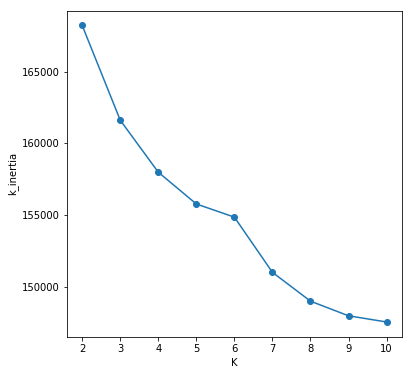

In [ ]:
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(k_list, k_inertia, '-o')
plt.xlabel('K')
plt.ylabel('k_inertia');
#view raw

#### from above K vs K_intertia elbow plot we can get K = 5 

execute KMeans once again using K = 5

In [ ]:
km = KMeans(n_clusters=5,n_init=3,max_iter = 50)

km.fit(x_train_data)

kmn = km.labels_
X_train['kmean'] = kmn
x = X_train.groupby('kmean')

In [ ]:
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
for i in range(km.labels_.shape[0]):
    if km.labels_[i] == 0:
        cluster1.append(preprocessed_essays_train[i])
    elif km.labels_[i] == 1:
        cluster2.append(preprocessed_essays_train[i])
    elif km.labels_[i] == 2:
        cluster3.append(preprocessed_essays_train[i])  
    elif km.labels_[i] == 3:
        cluster4.append(preprocessed_essays_train[i])
    elif km.labels_[i] == 4:
        cluster5.append(preprocessed_essays_train[i])        

### Word Cloud for cluster 1 

In [ ]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
c_words =''
for val in cluster1: 
    val = str(val) 
    word = val.split() 
    for i in range(len(word)): 
        word[i] = word[i].lower() 
    for j in word: 
        c_words = c_words + j + ' '

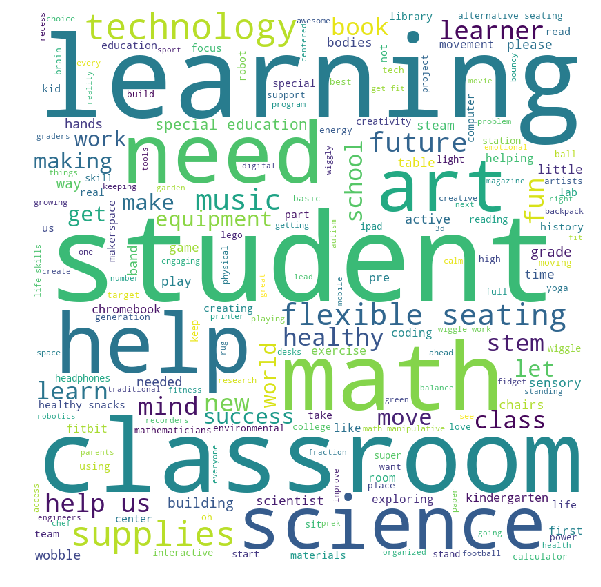

In [ ]:
from wordcloud import WordCloud       
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(c_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### Summarize cluster 1 by manually observing few points

In [ ]:
x.get_group(0)[1:5]

Unnamed: 0       id                        teacher_id teacher_prefix  \
46172      123333  p083252  c8b8e2337f1deaa7cd575e1354974099           Mrs.   
21425      144657  p156573  dea031e95ba81c0ba8b5787a701d300e           Mrs.   
82456       87628  p176784  92748a48f141901486af09042125d9d6           Mrs.   
95258       91278  p039301  922799fa1a1badb4673f9f28b59a737a            Ms.   

      school_state project_submitted_datetime project_grade_category  \
46172           IL        2016-11-06 09:43:45             Grades 3-5   
21425           IL        2016-12-12 22:26:44             Grades 6-8   
82456           IL        2016-07-02 16:21:53          Grades PreK-2   
95258           IL        2017-03-20 13:15:21             Grades 3-5   

      project_subject_categories       project_subject_subcategories  \
46172             Math & Science  Health & Life Science, Mathematics   
21425            Health & Sports                         Team Sports   
82456           History & Civics                 History & Geography   
95258      Warmth, Care & Hunger               Warmth, Care & Hunger   

                                           project_title  ...   \
46172                         Flexible Seating for More!  ...    
21425                     Help our Mighty Eagles get FIT  ...    
82456                               A Rug for My Rugrats  ...    
95258  There Is Nothing Basic About Meeting Basic Needs!  ...    

                                project_resource_summary  \
46172  My students need balls, buoys, and cushions fo...   
21425  My students need yoga mats and dumbbells to he...   
82456  My students need a carpet for classroom learni...   
95258  My students need basic hygiene supplies that t...   

      teacher_number_of_previously_posted_projects project_is_approved  \
46172                                            0                   1   
21425                                            0                   1   
82456                                            2                   1   
95258                                            5                   1   

        price quantity                                              essay  \
46172  257.98        6  “This is so cool”.  This is just one of the qu...   
21425   69.98       23  My students come from low income households, c...   
82456  288.96        1  Year after year, I find my classroom is filled...   
95258   85.21       16  I am the sole school counselor at an ethnicall...   

         clean_categories             clean_subcategories  dbscn kmean  
46172        Math_Science  Health_LifeScience Mathematics      0     0  
21425       Health_Sports                      TeamSports      0     0  
82456      History_Civics               History_Geography      0     0  
95258  Warmth Care_Hunger              Warmth Care_Hunger      0     0  

[4 rows x 24 columns]

### Word Cloud for cluster 2

In [ ]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
c_words =''
for val in cluster2: 
    val = str(val) 
    word = val.split() 
    for i in range(len(word)): 
        word[i] = word[i].lower() 
    for j in word: 
        c_words = c_words + j + ' '

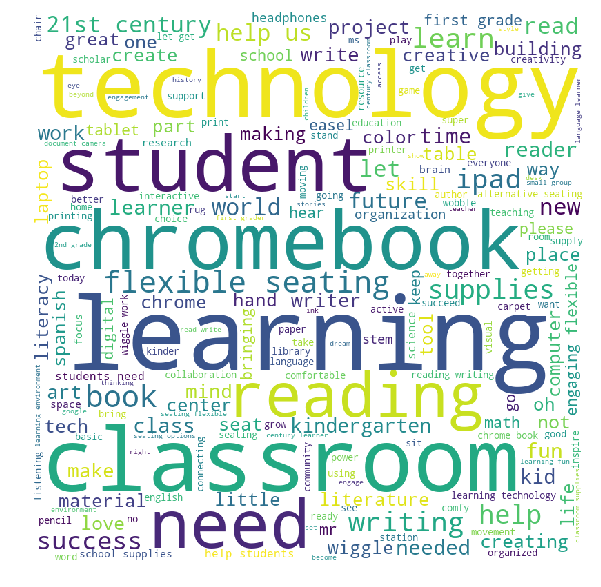

In [ ]:
from wordcloud import WordCloud       
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(c_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

###  Summarize cluster 2 by manually observing few points

In [ ]:
x.get_group(1)[1:5]

Unnamed: 0       id                        teacher_id teacher_prefix  \
13450        2451  p149617  9db5da5d6079e7694b11bce65bbac22f            Ms.   
27190      109824  p232121  223589b8dd25a309bd435960b10497d0            Mr.   
86230       19496  p114330  a628a35e88a32834762fc6cba3e8f111           Mrs.   
58098      152019  p090175  f7485859b072d9fbbfa2c9ac3b07cf20            Ms.   

      school_state project_submitted_datetime project_grade_category  \
13450           MO        2017-03-09 19:00:21          Grades PreK-2   
27190           CA        2017-04-13 18:47:48            Grades 9-12   
86230           AL        2017-02-13 17:31:40          Grades PreK-2   
58098           MA        2016-08-17 16:53:13             Grades 3-5   

                  project_subject_categories  \
13450    Literacy & Language, Math & Science   
27190     Literacy & Language, Special Needs   
86230    Literacy & Language, Math & Science   
58098  Applied Learning, Literacy & Language   

                   project_subject_subcategories  \
13450          Literature & Writing, Mathematics   
27190        Literature & Writing, Special Needs   
86230          Literature & Writing, Mathematics   
58098  Character Education, Literature & Writing   

                                           project_title  ...   \
13450  Flexible Seating: A New Way for Students to  L...  ...    
27190                                Widescreen Learning  ...    
86230                          Rocking with Chromebooks!  ...    
58098                                   Feeding Our Mind  ...    

                                project_resource_summary  \
13450  My students need these items to become active,...   
27190  My students need to see what they are learning...   
86230  My students need four Chromebooks to enhance t...   
58098  My students need a projector for their reading...   

      teacher_number_of_previously_posted_projects project_is_approved  \
13450                                            0                   0   
27190                                            4                   1   
86230                                           14                   1   
58098                                            0                   1   

         price quantity                                              essay  \
13450   198.91       12  As I pick up my classroom from the gym, I'm gr...   
27190  1735.27        2  Teaching in special education is the greatest ...   
86230   183.13        4  My students are a very energetic group of indi...   
58098  1198.60       30  I teach third grade in a Boston Public School....   

                        clean_categories  \
13450     Literacy_Language Math_Science   
27190     Literacy_Language SpecialNeeds   
86230     Literacy_Language Math_Science   
58098  AppliedLearning Literacy_Language   

                         clean_subcategories  dbscn kmean  
13450         Literature_Writing Mathematics      0     1  
27190        Literature_Writing SpecialNeeds      0     1  
86230         Literature_Writing Mathematics      0     1  
58098  CharacterEducation Literature_Writing      0     1  

[4 rows x 24 columns]

### Word Cloud for cluster 3

In [ ]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
c_words =''
for val in cluster3: 
    val = str(val) 
    word = val.split() 
    for i in range(len(word)): 
        word[i] = word[i].lower() 
    for j in word: 
        c_words = c_words + j + ' '

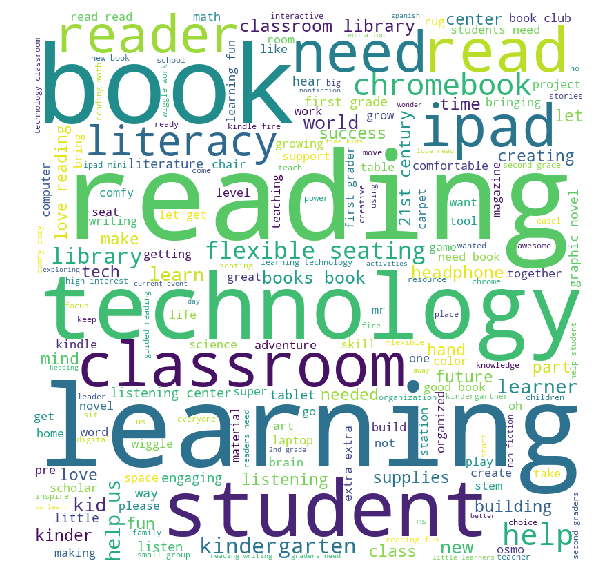

In [ ]:
from wordcloud import WordCloud       
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(c_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### Summarize cluster 3 by manually observing few points

In [ ]:
x.get_group(2)[1:5]

Unnamed: 0       id                        teacher_id teacher_prefix  \
60778        8063  p111584  d8c90d67c65ba07fc1c66c5f8ebb10bb           Mrs.   
46808       67443  p219531  e0b2f1b5d63b404adcba99edcc59d9d8           Mrs.   
9665       117958  p178447  5cdde5f0499174f1975c2f509144f806           Mrs.   
9192        83402  p111052  9d56638893b8bfa34b476055d6b7d2ea        Teacher   

      school_state project_submitted_datetime project_grade_category  \
60778           KY        2016-05-09 15:43:09          Grades PreK-2   
46808           TX        2016-11-29 15:28:35          Grades PreK-2   
9665            SC        2016-11-15 20:59:10             Grades 3-5   
9192            LA        2016-05-22 23:06:41          Grades PreK-2   

                project_subject_categories   project_subject_subcategories  \
60778                  Literacy & Language  Literacy, Literature & Writing   
46808   Literacy & Language, Special Needs         Literacy, Special Needs   
9665   Literacy & Language, Math & Science           Literacy, Mathematics   
9192   Literacy & Language, Math & Science           Literacy, Mathematics   

                                        project_title  ...   \
60778  Classroom Gathering, Sharing, and Learning Rug  ...    
46808               We Need Indestructible Materials!  ...    
9665                     If They Break It, It Is Done  ...    
9192            USING OUR HANDS TO MOTIVATE OUR MINDS  ...    

                                project_resource_summary  \
60778  My students need an area rug to gather, discus...   
46808  My students need durable, reusable supplies to...   
9665   My students need 19 protective cases for our i...   
9192   My students need these items as an aid to insu...   

      teacher_number_of_previously_posted_projects project_is_approved  \
60778                                            0                   1   
46808                                            0                   1   
9665                                            87                   1   
9192                                             0                   1   

        price quantity                                              essay  \
60778  383.08        1  \"The more that you read, the more things you ...   
46808  197.88        5  My students are deaf or hard of hearing, but t...   
9665     9.99       19  STEM instruction is taking the nation by storm...   
9192   506.94       11  GT school is located in a traditional neighbor...   

                     clean_categories          clean_subcategories  dbscn  \
60778               Literacy_Language  Literacy Literature_Writing      0   
46808  Literacy_Language SpecialNeeds        Literacy SpecialNeeds      0   
9665   Literacy_Language Math_Science         Literacy Mathematics      0   
9192   Literacy_Language Math_Science         Literacy Mathematics      0   

      kmean  
60778     2  
46808     2  
9665      2  
9192      2  

[4 rows x 24 columns]

### Word Cloud for cluster 4

In [ ]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
c_words =''
for val in cluster4: 
    val = str(val) 
    word = val.split() 
    for i in range(len(word)): 
        word[i] = word[i].lower() 
    for j in word: 
        c_words = c_words + j + ' '

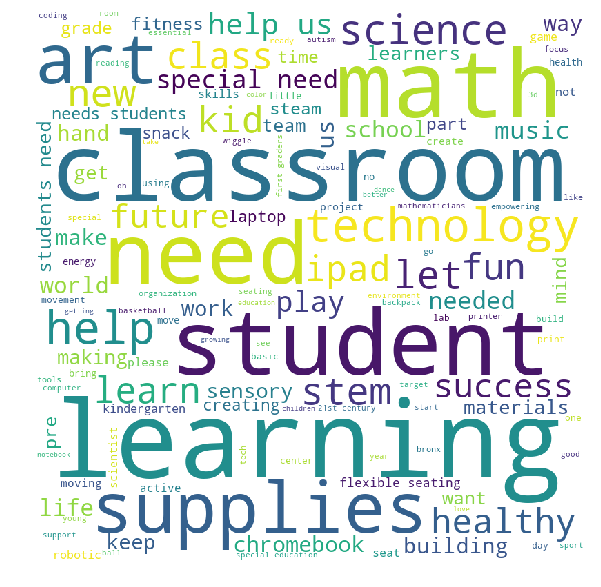

In [ ]:
from wordcloud import WordCloud       
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(c_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### Summarize cluster 4 by manually observing few points

In [ ]:
x.get_group(3)[1:5]

Unnamed: 0       id                        teacher_id teacher_prefix  \
58304        65722  p086724  56a7fe14cfe6e3af27e652fb083a06dc        Teacher   
104690      132090  p077247  a129dae65ce3527550b710f0abcf09e3            Ms.   
38348       150331  p141745  084871b5dc4d9c87f2194530e8ad685d           Mrs.   
11795       108765  p225808  2aeb751459c0a0974e972730e55472d2            Ms.   

       school_state project_submitted_datetime project_grade_category  \
58304            NY        2016-08-16 23:58:58          Grades PreK-2   
104690           NY        2016-10-07 07:01:21             Grades 3-5   
38348            NY        2016-11-02 12:03:03            Grades 9-12   
11795            NY        2017-01-15 17:14:57             Grades 3-5   

                project_subject_categories  \
58304                      Health & Sports   
104690                     Health & Sports   
38348   Applied Learning, Music & The Arts   
11795                        Special Needs   

             project_subject_subcategories  \
58304     Gym & Fitness, Health & Wellness   
104690    Gym & Fitness, Health & Wellness   
38348   College & Career Prep, Visual Arts   
11795                        Special Needs   

                                            project_title  ...   \
58304                                 Let's Get Physical!  ...    
104690  Help special needs students wiggle while they ...  ...    
38348                 Crafty Supplies for Crafty Students  ...    
11795   Capture Knowledge Through the \"Net\" with Chr...  ...    

                                 project_resource_summary  \
58304   My students need some really good equipment to...   
104690  My students need specialized seating such as h...   
38348   My students need craft supplies including spec...   
11795   My students need one Chromebook to explore the...   

       teacher_number_of_previously_posted_projects project_is_approved  \
58304                                             0                   1   
104690                                           10                   1   
38348                                           100                   1   
11795                                             3                   1   

         price quantity                                              essay  \
58304   327.41       14  My pre-k students are in need of some outdoor ...   
104690  107.06        6  As a teacher in a low-income/high poverty scho...   
38348   200.52       15  My students have so little and I want to give ...   
11795   295.81        2  They all have different interests, but they wi...   

                  clean_categories            clean_subcategories  dbscn kmean  
58304                Health_Sports    Gym_Fitness Health_Wellness      0     3  
104690               Health_Sports    Gym_Fitness Health_Wellness      0     3  
38348   AppliedLearning Music_Arts  College_CareerPrep VisualArts      0     3  
11795                 SpecialNeeds                   SpecialNeeds      0     3  

[4 rows x 24 columns]

### Word Cloud for cluster 5

In [ ]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
c_words =''
for val in cluster5: 
    val = str(val) 
    word = val.split() 
    for i in range(len(word)): 
        word[i] = word[i].lower() 
    for j in word: 
        c_words = c_words + j + ' '

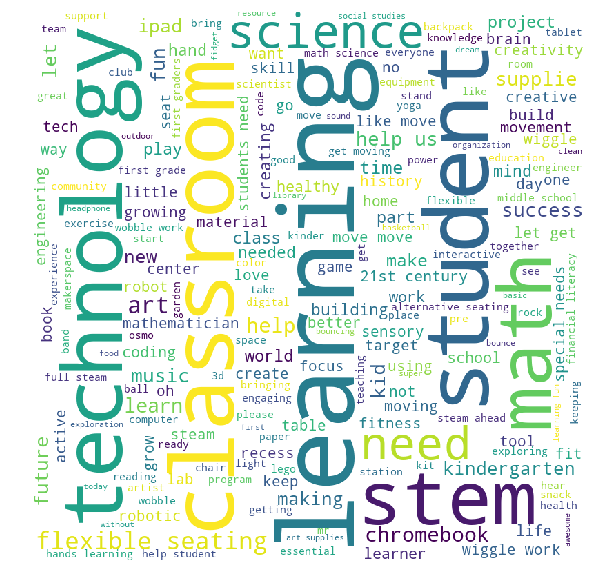

In [ ]:
from wordcloud import WordCloud       
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(c_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### Summarize cluster 5 by manually observing few points

In [ ]:
x.get_group(3=4)[1:5]

Unnamed: 0       id                        teacher_id teacher_prefix  \
12839      169479  p099180  741f9a91c57c379adc8fb31d98d5a610            Ms.   
27109      124111  p075811  1f64dcec848be8e95c4482cc845706b2           Mrs.   
19119       14709  p051093  3b2e66e8288a1d1674f961c18799f8c6           Mrs.   
89979       62529  p166380  5cbe40d53e20c648c6c8c442b6cd4909           Mrs.   

      school_state project_submitted_datetime project_grade_category  \
12839           CA        2016-09-01 15:53:56          Grades PreK-2   
27109           CA        2016-12-12 21:45:35          Grades PreK-2   
19119           WY        2017-02-16 14:12:46             Grades 3-5   
89979           NC        2017-04-13 14:47:48             Grades 6-8   

             project_subject_categories project_subject_subcategories  \
12839                     Special Needs                 Special Needs   
27109             Warmth, Care & Hunger         Warmth, Care & Hunger   
19119             Warmth, Care & Hunger         Warmth, Care & Hunger   
89979  Math & Science, Applied Learning       Applied Sciences, Other   

                                           project_title  ...   \
12839  Help Special Needs Students Have Meaningful Cl...  ...    
27109        Rainy Days and Mondays Always Gets Me Down!  ...    
19119                                   Caring Commuinty  ...    
89979                            Electric Flow and Glow!  ...    

                                project_resource_summary  \
12839  My students need sight words and reading readi...   
27109  My students need umbrellas, ponchos, cups, and...   
19119  My students need these tee shirts to show thei...   
89979  My students need basic electricity materials t...   

      teacher_number_of_previously_posted_projects project_is_approved  \
12839                                            9                   1   
27109                                          288                   1   
19119                                            5                   1   
89979                                            2                   1   

        price quantity                                              essay  \
12839  476.09       29  My students are unique learners in more ways t...   
27109  105.44       33  My students are incredible! I have 24 motivate...   
19119   46.16       20  Cottonwood students are amazing kids. They hav...   
89979  225.40       13  Middle school! Hormones, social media, sports ...   

                   clean_categories    clean_subcategories  dbscn kmean  
12839                  SpecialNeeds           SpecialNeeds      0     4  
27109            Warmth Care_Hunger     Warmth Care_Hunger      0     4  
19119            Warmth Care_Hunger     Warmth Care_Hunger      0     4  
89979  Math_Science AppliedLearning  AppliedSciences Other      0     4  

[4 rows x 24 columns]

## Agglomerative Clustering

### Cluster size = 2

In [ ]:
from sklearn.cluster import AgglomerativeClustering
agl = AgglomerativeClustering(n_clusters=2)
agl.fit(x_train_data.toarray())
    

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

In [ ]:
agl.labels_.shape[0]

49039

In [ ]:
agl1 = agl.labels_
X_train['agl1'] = agl1
x = X_train.groupby('agl1')

In [ ]:
cluster1 = []
cluster2 = []
for i in range(agl.labels_.shape[0]):
    if agl.labels_[i] == 0:
        cluster1.append(preprocessed_essays_train[i])
    else:
        cluster2.append(preprocessed_essays_train[i])
    

### Word Cloud for cluster 1 

In [ ]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
c_words =''
for val in cluster1: 
    val = str(val) 
    word = val.split() 
    for i in range(len(word)): 
        word[i] = word[i].lower() 
    for j in word: 
        c_words = c_words + j + ' '

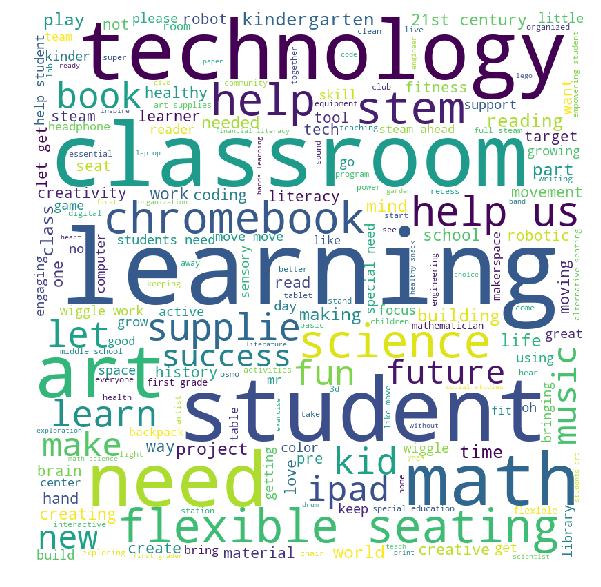

In [ ]:
from wordcloud import WordCloud       
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(c_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### Summarize cluster 1 by manually observing few points

In [ ]:
x.get_group(0)[1:6]

Unnamed: 0       id                        teacher_id teacher_prefix  \
69154      124381  p071852  9e04fee2ed390cb8f01eb303ea799842            Ms.   
46808       67443  p219531  e0b2f1b5d63b404adcba99edcc59d9d8           Mrs.   
9665       117958  p178447  5cdde5f0499174f1975c2f509144f806           Mrs.   
55561      133624  p006515  0860b1b35ae510dd478402fc4f0242ae           Mrs.   
9192        83402  p111052  9d56638893b8bfa34b476055d6b7d2ea        Teacher   

      school_state project_submitted_datetime project_grade_category  \
69154           MD        2017-04-07 13:39:52          Grades PreK-2   
46808           TX        2016-11-29 15:28:35          Grades PreK-2   
9665            SC        2016-11-15 20:59:10             Grades 3-5   
55561           NY        2016-05-18 10:30:14          Grades PreK-2   
9192            LA        2016-05-22 23:06:41          Grades PreK-2   

                project_subject_categories     project_subject_subcategories  \
69154      Applied Learning, Special Needs  Early Development, Special Needs   
46808   Literacy & Language, Special Needs           Literacy, Special Needs   
9665   Literacy & Language, Math & Science             Literacy, Mathematics   
55561                        Special Needs                     Special Needs   
9192   Literacy & Language, Math & Science             Literacy, Mathematics   

                                  project_title ...   \
69154  Alternative seating for Active Achievers ...    
46808         We Need Indestructible Materials! ...    
9665               If They Break It, It Is Done ...    
55561          iPads For Special Needs Students ...    
9192      USING OUR HANDS TO MOTIVATE OUR MINDS ...    

      teacher_number_of_previously_posted_projects project_is_approved  \
69154                                            0                   0   
46808                                            0                   1   
9665                                            87                   1   
55561                                            0                   1   
9192                                             0                   1   

        price quantity                                              essay  \
69154  341.47        5  I teach five amazing students in pre-k and kin...   
46808  197.88        5  My students are deaf or hard of hearing, but t...   
9665     9.99       19  STEM instruction is taking the nation by storm...   
55561  344.93        3  I am an occupational therapist in a high needs...   
9192   506.94       11  GT school is located in a traditional neighbor...   

                     clean_categories            clean_subcategories  dbscn  \
69154    AppliedLearning SpecialNeeds  EarlyDevelopment SpecialNeeds      0   
46808  Literacy_Language SpecialNeeds          Literacy SpecialNeeds      0   
9665   Literacy_Language Math_Science           Literacy Mathematics      0   
55561                    SpecialNeeds                   SpecialNeeds      0   
9192   Literacy_Language Math_Science           Literacy Mathematics      0   

       kmean agl1  
69154      4    0  
46808      2    0  
9665       2    0  
55561      3    0  
9192       2    0  

[5 rows x 25 columns]

### Word Cloud for cluster 2

In [ ]:
c_words =''
for val in cluster2: 
    val = str(val) 
    word = val.split() 
    for i in range(len(word)): 
        word[i] = word[i].lower() 
    for j in word: 
        c_words = c_words + j + ' '

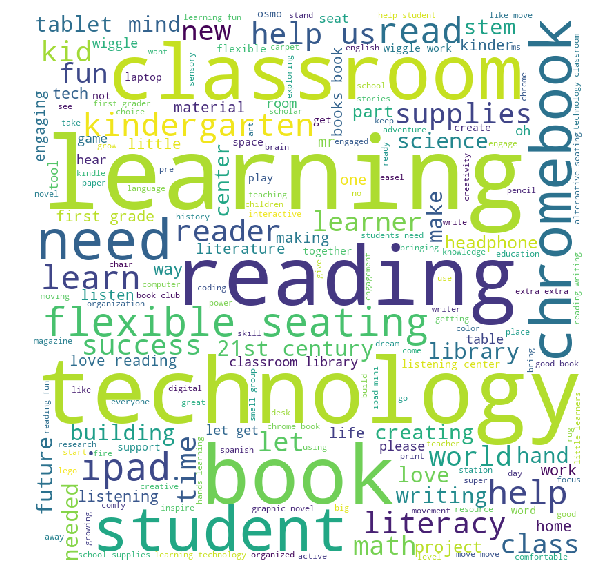

In [ ]:
from wordcloud import WordCloud       
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(c_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### Summarize cluster 2 by manually observing few points

In [ ]:
x.get_group(-1)[1:6]

Unnamed: 0       id                        teacher_id teacher_prefix  \
76524        89538  p235151  e9fd1921b90a0be8fb5d7618945d7fe7           Mrs.   
55901        62919  p143917  b5b261b07886b4265425770cdccf2a71            Ms.   
7656         52317  p230875  be8786b4a0f56e8beb28c5aa7409ba29           Mrs.   
108536      176389  p089101  99d5caab9a5840f1cb728f4a42047b87           Mrs.   
21564       158512  p168666  613ac392781124be92aecc0d8b251c43           Mrs.   

       school_state project_submitted_datetime project_grade_category  \
76524            PA        2016-08-13 21:09:27          Grades PreK-2   
55901            CA        2016-12-03 18:57:58             Grades 3-5   
7656             MI        2017-02-20 08:32:57             Grades 6-8   
108536           ME        2017-04-10 15:26:13             Grades 3-5   
21564            WI        2017-04-04 15:41:06          Grades PreK-2   

                 project_subject_categories   project_subject_subcategories  \
76524   Literacy & Language, Math & Science           Literacy, Mathematics   
55901                   Literacy & Language                        Literacy   
7656                  Warmth, Care & Hunger           Warmth, Care & Hunger   
108536                     Music & The Arts          Music, Performing Arts   
21564      Applied Learning, Math & Science  Early Development, Mathematics   

                                            project_title ...   \
76524                                First Grade Success! ...    
55901                               Looney for Toon Books ...    
7656    Maxi Pads Needed for Low-Income Middle School ... ...    
108536  Ukuleles will add Excitement to our Music \r\n... ...    
21564                       Hands-On Materials For Pre-K! ...    

       project_is_approved   price quantity  \
76524                    1   67.08       18   
55901                    1  126.66        1   
7656                     1   12.95       25   
108536                   1   59.00       12   
21564                    1  290.63        7   

                                                    essay  \
76524   I teach 25 first grade students in a large urb...   
55901   The opportunity to read various genres of lite...   
7656    I teach at an inner-city school that services ...   
108536  My students live in a rural community. These k...   
21564   Students come into school eager to learn and e...   

                      clean_categories           clean_subcategories  dbscn  \
76524   Literacy_Language Math_Science          Literacy Mathematics     -1   
55901                Literacy_Language                      Literacy     -1   
7656                Warmth Care_Hunger            Warmth Care_Hunger     -1   
108536                      Music_Arts          Music PerformingArts     -1   
21564     AppliedLearning Math_Science  EarlyDevelopment Mathematics     -1   

        kmean  agl1 agl2  
76524       2    -1   -1  
55901       2    -1   -1  
7656        4    -1   -1  
108536      4    -1   -1  
21564       4    -1   -1  

[5 rows x 26 columns]

### Cluster size = 3

In [ ]:
from sklearn.cluster import AgglomerativeClustering
agl1 = AgglomerativeClustering(n_clusters=3)
agl1.fit(x_train_data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func='deprecated')

In [ ]:
cluster1 = []
cluster2 = []
cluster3 = []
for i in range(agl1.labels_.shape[0]):
    if agl1.labels_[i] == 0:
        cluster1.append(preprocessed_essays_train[i])
    elif agl1.labels_[i] == 1:
        cluster2.append(preprocessed_essays_train[i])
    else:
        cluster3.append(preprocessed_essays_train[i])
    

In [ ]:
agl2 = agl1.labels_
X_train['agl2'] = agl2
x = X_train.groupby('agl2')

### Summarize cluster 1 by manually observing few points

In [ ]:
x.get_group(0)[1:5]

Unnamed: 0       id                        teacher_id teacher_prefix  \
14308       58771  p206624  027f806c2bfceb0e841110956228b7c5            Ms.   
92081       54367  p202159  66670ae81282034e10cb5c119ce27b49            Ms.   
12839      169479  p099180  741f9a91c57c379adc8fb31d98d5a610            Ms.   
89979       62529  p166380  5cbe40d53e20c648c6c8c442b6cd4909           Mrs.   

      school_state project_submitted_datetime project_grade_category  \
14308           NC        2016-07-15 12:02:56          Grades PreK-2   
92081           WI        2016-06-30 08:58:49             Grades 6-8   
12839           CA        2016-09-01 15:53:56          Grades PreK-2   
89979           NC        2017-04-13 14:47:48             Grades 6-8   

                project_subject_categories project_subject_subcategories  \
14308  Literacy & Language, Math & Science         Literacy, Mathematics   
92081                  Literacy & Language          Literature & Writing   
12839                        Special Needs                 Special Needs   
89979     Math & Science, Applied Learning       Applied Sciences, Other   

                                           project_title ...   \
14308                   Carpet Removed throughout School ...    
92081  Holy Bagumba! Help My Students Engage in Reading. ...    
12839  Help Special Needs Students Have Meaningful Cl... ...    
89979                            Electric Flow and Glow! ...    

      project_is_approved   price quantity  \
14308                   1  288.96        1   
92081                   1    6.56       30   
12839                   1  476.09       29   
89979                   1  225.40       13   

                                                   essay  \
14308  The  students come from a neighborhood that is...   
92081  My students attend a large urban middle school...   
12839  My students are unique learners in more ways t...   
89979  Middle school! Hormones, social media, sports ...   

                     clean_categories    clean_subcategories  dbscn  kmean  \
14308  Literacy_Language Math_Science   Literacy Mathematics      0      2   
92081               Literacy_Language     Literature_Writing      0      1   
12839                    SpecialNeeds           SpecialNeeds      0      4   
89979    Math_Science AppliedLearning  AppliedSciences Other      0      4   

       agl1 agl2  
14308     0    0  
92081     0    0  
12839     0    0  
89979     0    0  

[4 rows x 26 columns]

### Word Cloud for cluster 1 

In [ ]:
c_words =''
for val in cluster1: 
    val = str(val) 
    word = val.split() 
    for i in range(len(word)): 
        word[i] = word[i].lower() 
    for j in word: 
        c_words = c_words + j + ' '

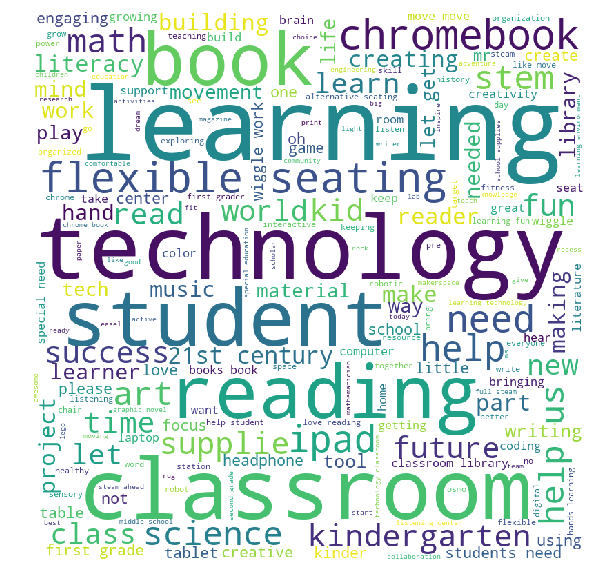

In [ ]:
from wordcloud import WordCloud       
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(c_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### Word Cloud for cluster 2

In [ ]:
c_words =''
for val in cluster2: 
    val = str(val) 
    word = val.split() 
    for i in range(len(word)): 
        word[i] = word[i].lower() 
    for j in word: 
        c_words = c_words + j + ' '

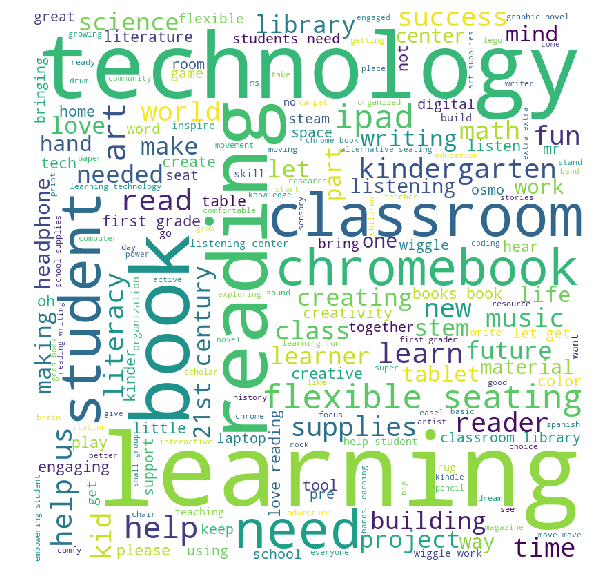

In [ ]:
from wordcloud import WordCloud       
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(c_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### Summarize cluster 2 by manually observing few points

In [ ]:
x.get_group(-1)[1:6]

Unnamed: 0       id                        teacher_id teacher_prefix  \
64509       86313  p070535  3f4f05e34b694b5945b9f70847227843            Ms.   
54050       92967  p048504  0543cd1ad15dfdf92c81c975831ae6b1           Mrs.   
82352      118223  p157494  f608b8fb8cb1a83fca993f62cda92fe7           Mrs.   
83859      180914  p014247  8dbd05f16ff7a75ffd4559e5e7a32136           Mrs.   
38270      162524  p178620  0cec7bc542967be06f547b9bf6f598b6            Ms.   

      school_state project_submitted_datetime project_grade_category  \
64509           VA        2017-03-13 16:06:52          Grades PreK-2   
54050           SC        2016-05-06 09:14:44             Grades 3-5   
82352           MI        2016-08-12 14:14:54          Grades PreK-2   
83859           NY        2017-03-07 15:27:51            Grades 9-12   
38270           CA        2016-08-16 23:27:13             Grades 3-5   

               project_subject_categories  \
64509    History & Civics, Math & Science   
54050                      Math & Science   
82352   Applied Learning, Health & Sports   
83859  Applied Learning, History & Civics   
38270                     Health & Sports   

                 project_subject_subcategories  \
64509         History & Geography, Mathematics   
54050  Applied Sciences, Environmental Science   
82352     Early Development, Health & Wellness   
83859         College & Career Prep, Economics   
38270           Health & Wellness, Team Sports   

                                           project_title ...   \
64509  Thinking Outside the Box  - Expanding Breakout... ...    
54050                           Breakout of the Ordinary ...    
82352  Kindergarten Wigglers Welcome! \r\nCome Learn ... ...    
83859     Help Harlem Tackle the AP Microeconomics Test! ...    
38270                        Double the Fun with Tennis! ...    

      project_is_approved   price quantity  \
64509                   1   45.78       19   
54050                   1  102.26       15   
82352                   1   69.95        4   
83859                   1   84.04       30   
38270                   0   99.97       23   

                                                   essay  \
64509  Our student body is pulled from a low-income/h...   
54050  Tired of doing the same old thing? Tired of le...   
82352  \"Sitting still is overrated. It makes sense f...   
83859  My students have opted to take Advanced Placem...   
38270  A new year and a new set of eager learners and...   

                     clean_categories                   clean_subcategories  \
64509     History_Civics Math_Science         History_Geography Mathematics   
54050                    Math_Science  AppliedSciences EnvironmentalScience   
82352   AppliedLearning Health_Sports      EarlyDevelopment Health_Wellness   
83859  AppliedLearning History_Civics          College_CareerPrep Economics   
38270                   Health_Sports            Health_Wellness TeamSports   

       dbscn  kmean  agl1 agl2  
64509     -1      4    -1   -1  
54050     -1      4    -1   -1  
82352     -1      4    -1   -1  
83859     -1      3    -1   -1  
38270     -1      4    -1   -1  

[5 rows x 26 columns]

### Word Cloud for cluster 3

In [ ]:
c_words =''
for val in cluster3: 
    val = str(val) 
    word = val.split() 
    for i in range(len(word)): 
        word[i] = word[i].lower() 
    for j in word: 
        c_words = c_words + j + ' '

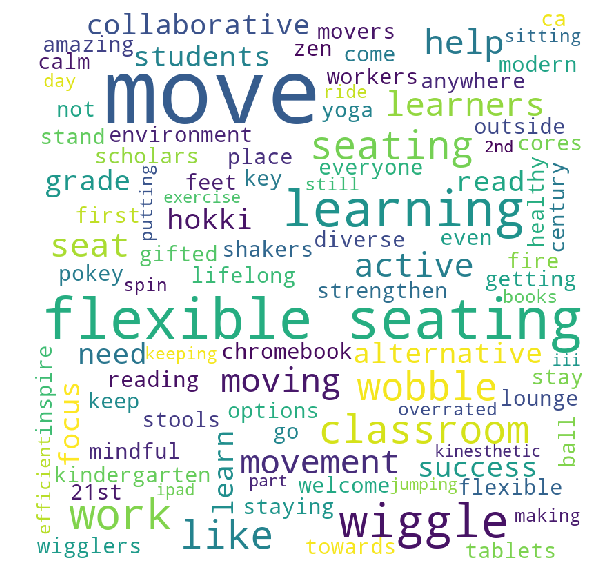

In [ ]:
from wordcloud import WordCloud       
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(c_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### Summarize cluster 3 by manually observing few points

In [ ]:
x.get_group(1)[1:5]

Unnamed: 0       id                        teacher_id teacher_prefix  \
19119       14709  p051093  3b2e66e8288a1d1674f961c18799f8c6           Mrs.   
77426      149066  p187309  58ccf17c367544ed3fdb8dd59332eeb1            Ms.   
14177       63778  p142117  fd980c8792e7b5d48643076075f881e9            Ms.   
26034      114486  p025427  d56629de5e5e991d530d46e2b73555cf           Mrs.   

      school_state project_submitted_datetime project_grade_category  \
19119           WY        2017-02-16 14:12:46             Grades 3-5   
77426           DC        2017-03-21 14:37:02          Grades PreK-2   
14177           TX        2016-11-17 11:49:47          Grades PreK-2   
26034           IN        2016-11-15 19:09:28             Grades 3-5   

      project_subject_categories project_subject_subcategories  \
19119      Warmth, Care & Hunger         Warmth, Care & Hunger   
77426      Warmth, Care & Hunger         Warmth, Care & Hunger   
14177      Warmth, Care & Hunger         Warmth, Care & Hunger   
26034      Warmth, Care & Hunger         Warmth, Care & Hunger   

                               project_title ...  project_is_approved   price  \
19119                       Caring Commuinty ...                    1   46.16   
77426  Warm, Comfortable and Ready to Learn! ...                    1   64.32   
14177               Backpacks for 2nd Grade! ...                    1  385.91   
26034              Backpacks Like My Friends ...                    1  137.93   

      quantity                                              essay  \
19119       20  Cottonwood students are amazing kids. They hav...   
77426        8  I teach 17 wonderful 3, 4, and 5-year-olds in ...   
14177       17  My students come from underprivileged homes wi...   
26034       25  Approximately 60% of the students in my classr...   

         clean_categories  clean_subcategories  dbscn  kmean  agl1 agl2  
19119  Warmth Care_Hunger   Warmth Care_Hunger      0      4     0    1  
77426  Warmth Care_Hunger   Warmth Care_Hunger      0      4     0    1  
14177  Warmth Care_Hunger   Warmth Care_Hunger      0      4     0    1  
26034  Warmth Care_Hunger   Warmth Care_Hunger      0      4     0    1  

[4 rows x 26 columns]

## DBSCAN Clustering

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_data = scaler.fit_transform(x_train_data.toarray())

In [ ]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components = 100)
x_train_data1 = tsvd.fit_transform(x_train_data)

In [ ]:
points = 2 * x_train_data1.shape[1]
dist = []
for i in x_train_data1:
    data = np.sort(np.sum((x_train_data1 - i)**2,axis=1),axis = None)
    dist.append(data[points])
 

In [ ]:
dist1 = np.sqrt(np.array(dist)) 
sort_dist = np.sort(dist1)
nlen = len(x_train_data)
NoOfPoint = [j for j in range(nlen)] 

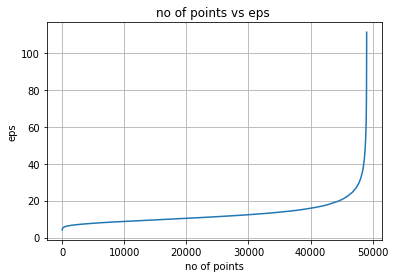

In [ ]:
plt.plot(NoOfPoint, sort_dist)
plt.xlabel('no of points')
plt.ylabel('eps')
plt.grid()
plt.title("no of points vs eps ")
plt.show()

#####  from above elbow plot we can get eps = 20

In [ ]:
from sklearn.cluster import DBSCAN
dbscn = DBSCAN(eps = 20,min_samples = points,n_jobs = -1 ).fit(x_train_data1)

In [ ]:
lb = dbscn.labels_
X_train['dbscn'] = lb
x = X_train.groupby('dbscn')

In [ ]:
NoOfCluster = len(set(dbscn.labels_))
NoOfCluster

2

Number of cluster =2

In [ ]:
cluster1 = []
cluster2 = []
for i in range(dbscn.labels_.shape[0]):
    if dbscn.labels_[i] == 0:
        cluster1.append(preprocessed_essays_train[i])
    else:
        cluster2.append(preprocessed_essays_train[i])
    

### Word Cloud for cluster 1 

In [ ]:
c_words =''
for val in cluster1: 
    val = str(val) 
    word = val.split() 
    for i in range(len(word)): 
        word[i] = word[i].lower() 
    for j in word: 
        c_words = c_words + j + ' '

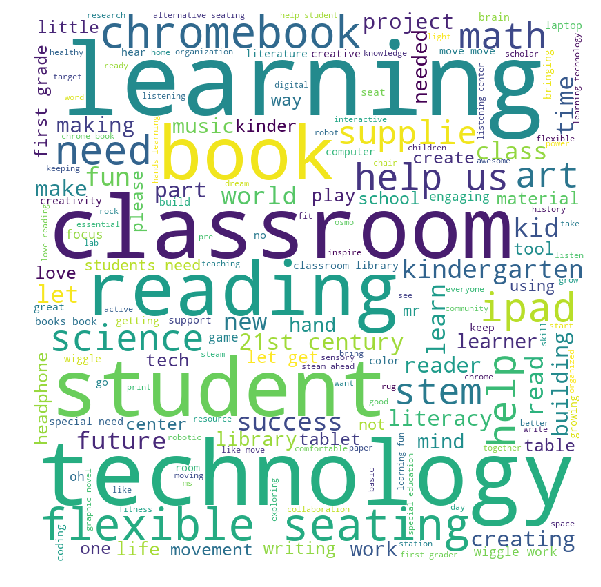

In [ ]:
from wordcloud import WordCloud       
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(c_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### Summarize cluster 1 by manually observing few points

In [ ]:
x.get_group(0)[1:5]

Unnamed: 0       id                        teacher_id teacher_prefix  \
14308       58771  p206624  027f806c2bfceb0e841110956228b7c5            Ms.   
92081       54367  p202159  66670ae81282034e10cb5c119ce27b49            Ms.   
12839      169479  p099180  741f9a91c57c379adc8fb31d98d5a610            Ms.   
27109      124111  p075811  1f64dcec848be8e95c4482cc845706b2           Mrs.   

      school_state project_submitted_datetime project_grade_category  \
14308           NC        2016-07-15 12:02:56          Grades PreK-2   
92081           WI        2016-06-30 08:58:49             Grades 6-8   
12839           CA        2016-09-01 15:53:56          Grades PreK-2   
27109           CA        2016-12-12 21:45:35          Grades PreK-2   

                project_subject_categories project_subject_subcategories  \
14308  Literacy & Language, Math & Science         Literacy, Mathematics   
92081                  Literacy & Language          Literature & Writing   
12839                        Special Needs                 Special Needs   
27109                Warmth, Care & Hunger         Warmth, Care & Hunger   

                                           project_title  ...   \
14308                   Carpet Removed throughout School  ...    
92081  Holy Bagumba! Help My Students Engage in Reading.  ...    
12839  Help Special Needs Students Have Meaningful Cl...  ...    
27109        Rainy Days and Mondays Always Gets Me Down!  ...    

      project_essay_4                           project_resource_summary  \
14308             NaN  My students need a meeting area in our flexibl...   
92081             NaN  My students need 30 copies of the book Flora a...   
12839             NaN  My students need sight words and reading readi...   
27109             NaN  My students need umbrellas, ponchos, cups, and...   

      teacher_number_of_previously_posted_projects project_is_approved  \
14308                                            0                   1   
92081                                            0                   1   
12839                                            9                   1   
27109                                          288                   1   

        price  quantity                                              essay  \
14308  288.96         1  The  students come from a neighborhood that is...   
92081    6.56        30  My students attend a large urban middle school...   
12839  476.09        29  My students are unique learners in more ways t...   
27109  105.44        33  My students are incredible! I have 24 motivate...   

                     clean_categories   clean_subcategories dbscn  
14308  Literacy_Language Math_Science  Literacy Mathematics     0  
92081               Literacy_Language    Literature_Writing     0  
12839                    SpecialNeeds          SpecialNeeds     0  
27109              Warmth Care_Hunger    Warmth Care_Hunger     0  

[4 rows x 23 columns]

### Word Cloud for cluster 2

In [ ]:
c_words =''
for val in cluster2: 
    val = str(val) 
    word = val.split() 
    for i in range(len(word)): 
        word[i] = word[i].lower() 
    for j in word: 
        c_words = c_words + j + ' '

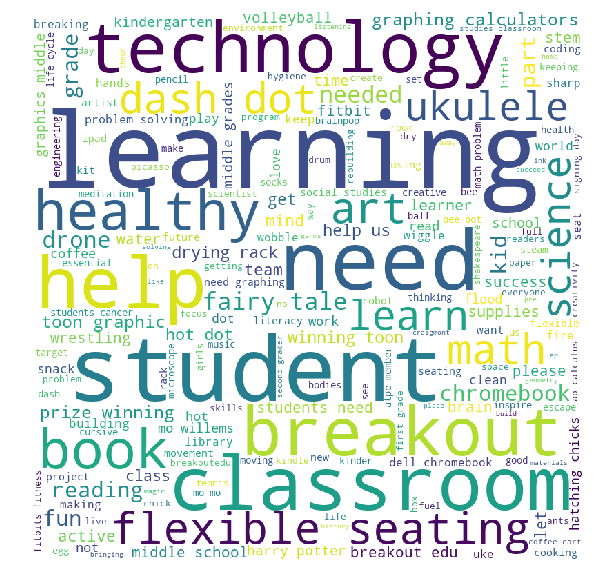

In [ ]:
from wordcloud import WordCloud       
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(c_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### Summarize cluster 2 by manually observing few points

In [ ]:
x.get_group(-1)[1:5]

Unnamed: 0       id                        teacher_id teacher_prefix  \
2190         36835  p173466  9a249191b1b67c22281dbe6899a001f7            Ms.   
13911       133777  p162875  881a61d6234dc63922f3c69b9a33e302            Ms.   
106869       89363  p182131  41a50d1eaeeb141817bf35fd3942bf4a            Ms.   
12960        67317  p176737  ec46972894cd49edc434d36c60a47094            Ms.   

       school_state project_submitted_datetime project_grade_category  \
2190             CA        2017-04-19 18:21:20             Grades 6-8   
13911            TX        2017-04-19 13:44:27            Grades 9-12   
106869           TX        2016-04-28 19:41:28          Grades PreK-2   
12960            IL        2017-01-03 11:34:39             Grades 6-8   

       project_subject_categories project_subject_subcategories  \
2190               Math & Science                   Mathematics   
13911       Warmth, Care & Hunger         Warmth, Care & Hunger   
106869           Applied Learning             Early Development   
12960         Literacy & Language             Foreign Languages   

                                            project_title  ...   \
2190    Help Students With Cancer Create Art Projects ...  ...    
13911                                Academic Signing Day  ...    
106869                               A Place for Everyone  ...    
12960                                Could you Breakout?!  ...    

                                          project_essay_4  \
2190                                                  NaN   
13911                                                 NaN   
106869  The rug will give us the opportunity to help b...   
12960                                                 NaN   

                                 project_resource_summary  \
2190    My students need art supplies and materials to...   
13911   My students need towels, cleaning supplies, sn...   
106869  My students need a new classroom rug to start ...   
12960   My students need these materials so we can cre...   

       teacher_number_of_previously_posted_projects project_is_approved  \
2190                                             36                   0   
13911                                             0                   1   
106869                                            8                   1   
12960                                             5                   1   

         price  quantity                                              essay  \
2190    101.18        41  My students are my heroes! My students are the...   
13911    91.47        91  Cedar Hill is an average size suburb of Dallas...   
106869  389.00         1  \"Sitting still is overrated. It makes sense f...   
12960   104.70        20  If you were to walk into my classroom, you wou...   

          clean_categories  clean_subcategories dbscn  
2190          Math_Science          Mathematics    -1  
13911   Warmth Care_Hunger   Warmth Care_Hunger    -1  
106869     AppliedLearning     EarlyDevelopment    -1  
12960    Literacy_Language     ForeignLanguages    -1  

[4 rows x 23 columns]

### Conclusion:

* We have considered TFIDF and SelectFromModel for feature selection.
* We have used 49039 datapoints for K-Means, Agglomerative and DBSCAN clustering.
* For K-Means, we have considered K -value from 2 to 10 and chosen best K value using elbow plot.
* For Agglomerative we have considered cluster size as 2 and 3.
* For DBSCAN clusterting we have calculated nth distance from each points and considered best EPS  value using elbow   plot.